In [1]:
import numpy as np
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Using Numpy backend.


In [45]:
def cancer():
    """Cancer model."""
    K = 100
    lambda_p = 0.121
    k_pq = 0.0295
    k_qpp = 0.0031
    delta_qp = 0.00867
    y = 0.729
    KDE = 0.24
    
    def f(state, t):
        C, P, Q, Qp = state
        MTD = P + Q + Qp
        dC = -KDE * C
        dP = lambda_p * P * (1 - MTD / K) + k_qpp * Qp - k_pq * P - y * C * KDE * P
        dQ = k_pq * P - y * C * KDE * Q
        dQp = y * C * KDE * Q - k_qpp * Qp - delta_qp * Qp
        return dC, dP, dQ, dQp
    return f

In [46]:
# pierwsza połowa - bez leczenia
C0 = 0
P0 = 7.13
Q0 = 41.2
Qp0 = 0
x0 = np.array([C0, P0, Q0, Qp0])
t = np.arange(0.0, 30.0, 0.1)
states_0 = odeint(cancer(), x0, t)
MTD_0 = states_0[:, 1] + states_0[:, 2] + states_0[:, 3]

# druga połowa - po wprowadzeniu dawki lekarstwa
C0 = 1
P0 = states_0[-1, 1]
Q0 = states_0[-1, 2]
Qp0 = states_0[-1, 3]
x0 = np.array([C0, P0, Q0, Qp0])
t = np.arange(30.0, 60.0, 0.1)
states_1 = odeint(cancer(), x0, t)
MTD_1 = states_1[:, 1] + states_1[:, 2] + states_1[:, 3]

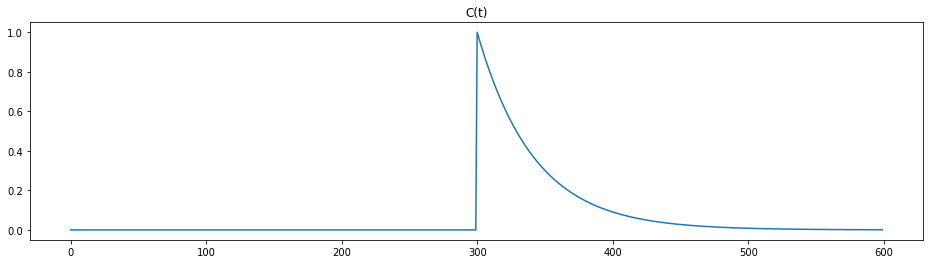

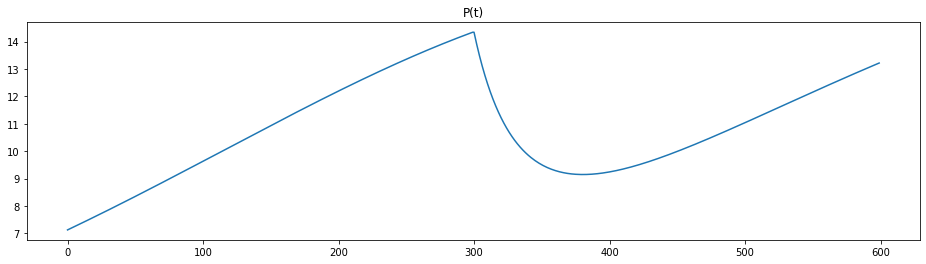

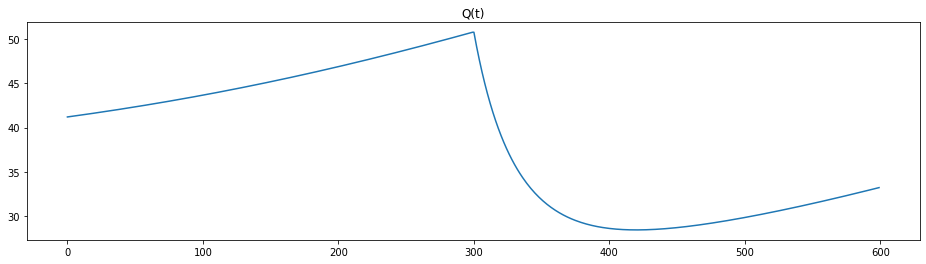

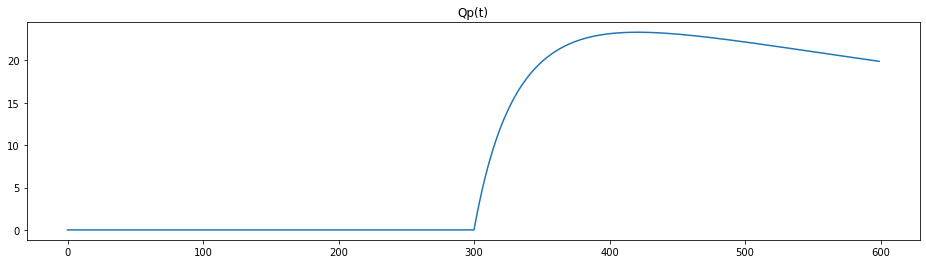

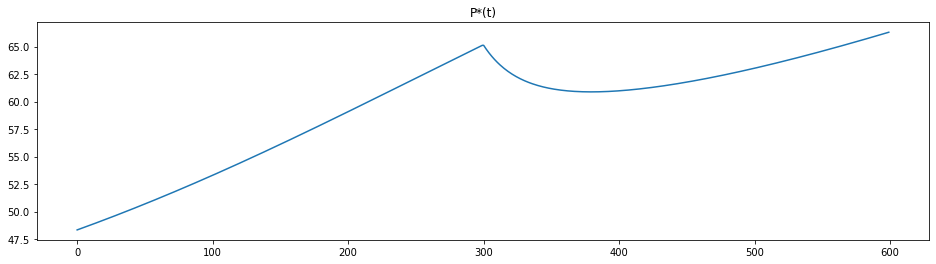

In [47]:
# złączenie danych
states = np.concatenate((states_0, states_1), axis=0)
MTD = np.concatenate((MTD_0, MTD_1), axis=0)

for i, title in [(0, 'C(t)'), (1, 'P(t)'), (2, 'Q(t)'), (3, 'Qp(t)')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(states[:, i])
    plt.show()
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.set_title('P*(t)')
ax.plot(MTD)
plt.show()

In [102]:
inputLength = len(states)
training_start = int(inputLength*0.5) # dane do treningu zaczynają się wraz z podaniem lekarstwa
training_end = int(inputLength*0.65)

inputData = MTD # dane wejściowe to P* = P + Q + Qp (inaczej MTD)
outputData = states[:, 1:] # na wyjściu chcemy P, Q, Qp, a z ich sumy policzymy P*

inputDataTraining = inputData[training_start:training_end]
inputDataValidation = inputData[training_end:]

outputDataTraining = outputData[training_start:training_end, :]
outputDataValidation = outputData[training_end:, :]

In [103]:
esn = PredictionESN(n_input=1, n_output=3, n_reservoir=50, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [104]:
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=2)

100% (90 of 90) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (47 of 47) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


0.49229531116443875

In [105]:
one_step_prediction = esn.predict(inputDataValidation)

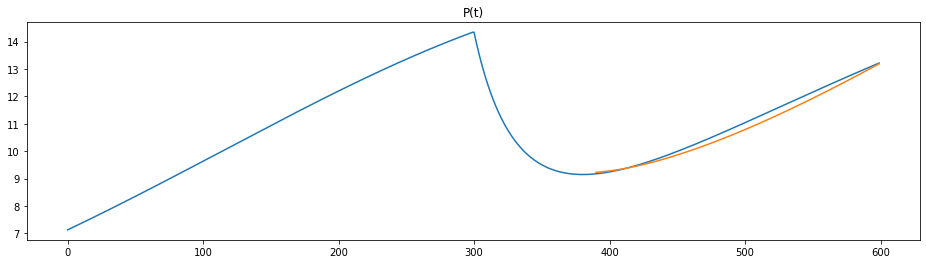

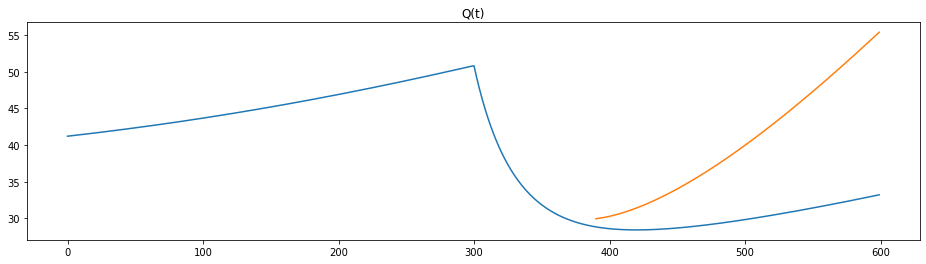

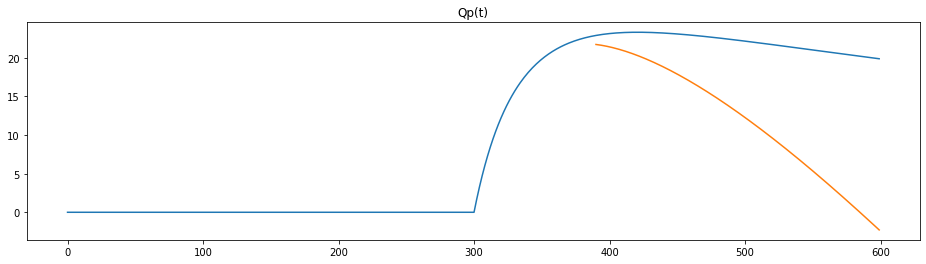

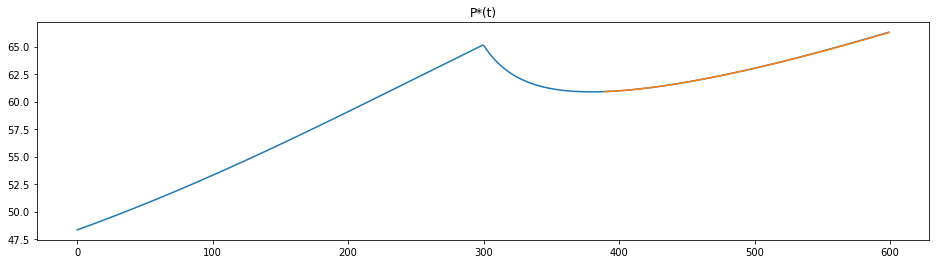

In [107]:
for i, title in [(0, 'P(t)'), (1, 'Q(t)'), (2, 'Qp(t)')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(range(inputLength), outputData[:, i], label='Real data')
    ax.plot(range(training_end, inputLength), one_step_prediction.T[i], label='Prediction')
    plt.show()

# predykcja P* policzona z sumy P, Q, Qp
MTD_pred = one_step_prediction.T[0] + one_step_prediction.T[1] + one_step_prediction.T[2]
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.set_title('P*(t)')
ax.plot(range(inputLength), MTD, label='Real data')
ax.plot(range(training_end, inputLength), MTD_pred, label='Prediction')
plt.show()